In [46]:
import pandas as pd
from datetime import datetime

In [47]:
#Cargar los datos
df = pd.read_excel('./OnlineRetail.xlsx')

In [48]:
#Preprocesamiento
#Asegurarse de que el total gastado es positivo y filtrar datos necesarios
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df = df[df['CustomerID'] > 0]
df ['TotalSpend'] = df['Quantity']*df['UnitPrice']


In [49]:
#Filtrar las filas donde Quantity, UnitPrice y CustomerID son mayores que 0
df = df[(df['Quantity']>0)&(df['UnitPrice']>0)&(df['CustomerID']>0)]

#Calcular el total de gasto
df['TotalSpend'] = df['Quantity']* df ['UnitPrice']

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalSpend   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [51]:
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalSpe

In [52]:
#calcular R, F, M
#NOW = datetime.now()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
NOW = df['InvoiceDate'].max()

RFM =df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (NOW - x.max()).days,
        'InvoiceNo': 'nunique', #nunique o count
        'TotalSpend': 'sum'
}).rename(columns={'InvoiceDate': 'Recency',
                   'InvoiceNo': 'Frequency',
                   'TotalSpend': 'Monetary'})

In [53]:
print(RFM)

            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1  77183.60
12347.0           1          7   4310.00
12348.0          74          4   1797.24
12349.0          18          1   1757.55
12350.0         309          1    334.40
...             ...        ...       ...
18280.0         277          1    180.60
18281.0         180          1     80.82
18282.0           7          2    178.05
18283.0           3         16   2094.88
18287.0          42          3   1837.28

[4338 rows x 3 columns]


In [54]:
#clasificar a los clientes en cuartiles
quartiles = RFM.quantile(q=[0.25, 0.5, 0.75])
quartiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,307.415
0.50,50.0,2.0,674.485
0.75,141.0,5.0,1661.740


In [55]:
#calculo de los Scores

RFM['R_Score'] = pd.cut(RFM['Recency'], bins = [-1, quartiles['Recency'][0.25], quartiles['Recency'][0.5],\
                                                 quartiles['Recency'][0.75], RFM ['Recency'].max()], labels = [4, 3, 2, 1], include_lowest=True)

In [56]:

RFM['F_Score'] = pd.cut(RFM['Frequency'], bins = [-1, quartiles['Frequency'][0.25], quartiles['Frequency'][0.5], \
                                                  quartiles['Frequency'][0.75], RFM ['Frequency'].max()], labels = [1,2,3,4], include_lowest=True)

In [57]:
RFM['M_Score'] = pd.cut(RFM['Monetary'], bins = [-1, quartiles['Monetary'][0.25], quartiles['Monetary'][0.5], \
                                                 quartiles['Monetary'][0.75], RFM ['Monetary'].max()], labels = [1,2,3,4], include_lowest=True)

In [58]:
quartiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,307.415
0.50,50.0,2.0,674.485
0.75,141.0,5.0,1661.740


In [59]:
RFM

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,4
12347.0,1,7,4310.00,4,4,4
12348.0,74,4,1797.24,2,3,4
12349.0,18,1,1757.55,3,1,4
12350.0,309,1,334.40,1,1,2
...,...,...,...,...,...,...
18280.0,277,1,180.60,1,1,1
18281.0,180,1,80.82,1,1,1
18282.0,7,2,178.05,4,2,1


In [60]:
#calcular el puntaje RFM total como una nueva columna
RFM['RFM_Score']=RFM['R_Score'].astype(str) + RFM ['F_Score'].astype(str) +RFM['M_Score'].astype(str)

In [61]:
#Segmentar a los cliente basados en el puntaje RFM
# Por ejemplo, '444' indica cliente con la mejor puntucacion en Recencia, Frecuencia, y Monetario
print(RFM.head())

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
CustomerID                                                                
12346.0         325          1  77183.60       1       1       4       114
12347.0           1          7   4310.00       4       4       4       444
12348.0          74          4   1797.24       2       3       4       234
12349.0          18          1   1757.55       3       1       4       314
12350.0         309          1    334.40       1       1       2       112


In [62]:
#constar el total de clientes en cada segemento de RFm score
rfm_score_counts = RFM['RFM_Score'].value_counts().reset_index()
rfm_score_counts.columns = ['RFM_Score', 'CustomerCount']

#Ordenar los resultados por RFM Score para mejor visualizaci[on]
rfm_score_counts = rfm_score_counts.sort_values(by='RFM_Score')

print (rfm_score_counts)

   RFM_Score  CustomerCount
1        111            443
2        112            222
34       113             39
44       114             11
24       121             63
..       ...            ...
15       434             90
57       441              2
56       442              2
23       443             63
0        444            462

[61 rows x 2 columns]


In [63]:
RFM['RFM_Score'].unique()

array(['114', '444', '234', '314', '112', '344', '111', '113', '334',
       '423', '222', '433', '122', '411', '324', '233', '313', '422',
       '123', '214', '223', '434', '134', '322', '212', '312', '132',
       '124', '213', '333', '311', '224', '424', '121', '244', '323',
       '443', '413', '412', '221', '332', '321', '232', '343', '211',
       '432', '143', '421', '144', '231', '331', '431', '243', '133',
       '131', '142', '414', '442', '441', '242', '141'], dtype=object)

In [64]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    4338 non-null   int64   
 1   Frequency  4338 non-null   int64   
 2   Monetary   4338 non-null   float64 
 3   R_Score    4338 non-null   category
 4   F_Score    4338 non-null   category
 5   M_Score    4338 non-null   category
 6   RFM_Score  4338 non-null   object  
dtypes: category(3), float64(1), int64(2), object(1)
memory usage: 182.8+ KB


In [65]:
#Filtrar para mostrar solo los clientes con RFM_Score de '444'

top_customers = RFM[RFM['RFM_Score']=='444']
print(top_customers)

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
CustomerID                                                                
12347.0           1          7   4310.00       4       4       4       444
12362.0           2         10   5226.23       4       4       4       444
12388.0          15          6   2780.66       4       4       4       444
12417.0           2          9   3649.10       4       4       4       444
12423.0           0          8   1859.31       4       4       4       444
...             ...        ...       ...     ...     ...     ...       ...
18230.0           8          7   2810.20       4       4       4       444
18241.0           9         17   2073.09       4       4       4       444
18245.0           6          7   2567.06       4       4       4       444
18272.0           2          6   3078.58       4       4       4       444
18283.0           3         16   2094.88       4       4       4       444

[462 rows x 7 columns]


In [66]:
# Primero , convertimos los puntajes a tipo int para las comparaciones
RFM['R_Score']=RFM['R_Score'].astype(int)
RFM['F_Score']=RFM['F_Score'].astype(int)
RFM['M_Score']=RFM['M_Score'].astype(int)

In [84]:
#Inicializamos la columna 'Segment' con 'Otros' para cubrir cualquier caso no explicito 
RFM ['Segment']='Otros'

#asignamos segmentos basados en condiciones especificas
RFM.loc[(RFM['R_Score']== 4)&(RFM['F_Score']==4)&(RFM['M_Score']==4),'Segment']='Mejores Clientes'
RFM.loc[(RFM['R_Score']== 4)&(RFM['Segment']=='Otros'),'Segment'] = 'Recientes'
RFM.loc[(RFM['F_Score']== 4)&(RFM['Segment']=='Otros'),'Segment'] = 'Frecuentes'
RFM.loc[(RFM['M_Score']== 4)&(RFM['Segment']=='Otros'),'Segment'] = 'Grandes Gastadores'
RFM.loc[(RFM['R_Score']== 4)&(RFM['Segment']=='Otros'),'Segment'] = 'En Riesgo'
RFM.loc[(RFM['R_Score']== 1)&(RFM['F_Score']==1)&(RFM['Segment']=='Otros'),'Segment']='Casi Perdidos'
RFM.loc[(RFM['F_Score']== 1)&(RFM['M_Score']==1)&(RFM['Segment']=='Otros'),'Segment']='Bajo Valor'


In [85]:
# Visualizamos la distribucion de los elementos
segment_distribution = RFM['Segment'].value_counts()
print(segment_distribution)

Segment
Otros                 1548
Casi Perdidos          704
Recientes              663
Mejores Clientes       462
Bajo Valor             353
Frecuentes             343
Grandes Gastadores     265
Name: count, dtype: int64


In [86]:
import matplotlib.pyplot as plt


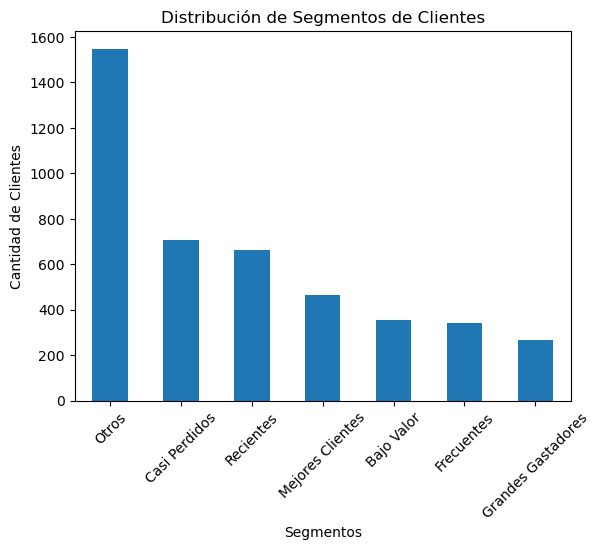

In [90]:
# Crear el gráfico de barras
fig, ax = plt.subplots()
segment_distribution.plot(kind='bar', ax=ax)
ax.set_xlabel('Segmentos')
ax.set_ylabel('Cantidad de Clientes')
ax.set_title('Distribución de Segmentos de Clientes')
plt.xticks(rotation=45)
plt.show()

In [95]:
# Crear una tabla a partir de segment_distribution
segment_distribution_table = segment_distribution.reset_index()
segment_distribution_table.columns = ['Segmento', 'Cantidad de Clientes']
# Mostrar la tabla en un formato bonito
print(segment_distribution_table)

             Segmento  Cantidad de Clientes
0               Otros                  1548
1       Casi Perdidos                   704
2           Recientes                   663
3    Mejores Clientes                   462
4          Bajo Valor                   353
5          Frecuentes                   343
6  Grandes Gastadores                   265


             Segmento  Total Monetario
4    Mejores Clientes      4369199.090
2          Frecuentes      1454127.700
5               Otros      1074028.303
3  Grandes Gastadores       878180.031
6           Recientes       870034.430
1       Casi Perdidos       204204.010
0          Bajo Valor        61634.340


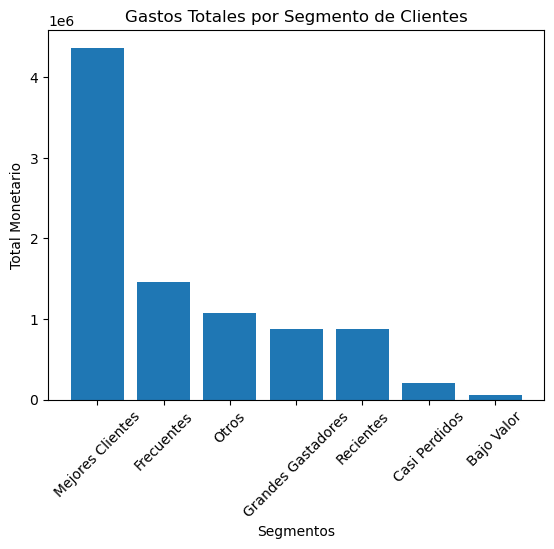

In [102]:
# Crear la tabla de suma de gastos por segmento
monetary_by_segment = RFM.groupby('Segment')['Monetary'].sum().reset_index()
monetary_by_segment.columns = ['Segmento', 'Total Monetario']

# Ordenar la tabla por el total monetario en orden descendente
monetary_by_segment = monetary_by_segment.sort_values(by='Total Monetario', ascending=False)

# Mostrar la tabla
print(monetary_by_segment)

# Crear el gráfico de barras
fig, ax = plt.subplots()
ax.bar(monetary_by_segment['Segmento'], monetary_by_segment['Total Monetario'])
ax.set_xlabel('Segmentos')
ax.set_ylabel('Total Monetario')
ax.set_title('Gastos Totales por Segmento de Clientes')
plt.xticks(rotation=45)
plt.show()